# Data Integrity

Coming out of the last section where we began showing some of the data challenges you'll run across, and hopefully you're starting to understand it's not just _read in the data and get to modeling_.  There's so much time devoted to getting the data, checking it, summarizing, asking questions, fixing issues, then rinse and repeat.  Real-world data is super messy and there's no one size fits all methodology.  Nearly every dataset will be unique and have some kind of peculiarities specific to the domain and data collections method.

Remember talking about "garbage in, garbage out"?  If your data is riddled with holes and untrustworthy data, then your entire model and project won't be worth a darn.  So again, be sure to give this EDA step all the attention it requires.  

Since you've already seen how to identify most of these issues, we're going to jump straight into addressing them.  In this section we'll cover the most common issues you'll run across.  There are others to be sure, but they'll be less common and more domain specific in most cases.

- Duplicate records
- Missing values/records
- Anomalous values/Outliers
- Sensoring

Below we'll speed up getting our data back into our environment and ready to tackle the integrity issues.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import plotnine as gg

# Read in the data from github repository
url = 'https://github.com/bradybr/practical-data-science-and-ml/blob/main/datasets/sleep_study.csv?raw=true'
dat = pd.read_csv(url, sep = ',')

# Create a list of the features you want to change and recast them using ".astype()"
vars = ['id']
dat[vars] = dat[vars].astype('object')
dat

,id,gender,age,country,study_begin,study_end,active_mins,sleep_disturb_mins,sleep_rem_mins
0,1,F,38.0,USA,4/3/2021,4/9/2023,96.8,227.5,25.9
1,2,M,72.0,Poland,4/3/2021,4/9/2023,245.6,644.2,86.7
2,3,F,95.0,Italy,4/3/2021,4/9/2023,279.4,465.6,31.8
3,4,M,37.0,USA,4/3/2021,4/9/2023,60.0,109.0,19.7
4,5,F,80.0,Spain,4/3/2021,4/9/2023,89.4,113.3,38.6
...,...,...,...,...,...,...,...,...,...
872,872,F,17.0,Italy,4/3/2021,4/9/2023,42.1,87.7,42.3
873,873,F,64.0,USA,4/3/2021,4/9/2023,128.5,268.8,23.4
874,874,F,27.0,Italy,4/3/2021,4/9/2023,43.2,84.1,18.0
875,875,F,69.0,Spain,4/3/2021,4/9/2023,246.8,237.6,44.1


<h3>Duplicate Records</h3>

Let's deal with the easiest ones first.  Remember we had a few duplicate observations?  Well, we spoke with our business expert, and she said there's no reason for those to exist and they are in fact real duplicate records.  We can go ahead and delete them.  

Easy enough.  Let's find them again and then we'll use the `.drop_duplicates()` function to drop them from our data.

In [2]:
# Check for duplicate observations
dat[dat.duplicated()]

,id,gender,age,country,study_begin,study_end,active_mins,sleep_disturb_mins,sleep_rem_mins
88,89,F,53.0,Italy,4/3/2021,4/9/2023,141.0,186.6,107.1
238,238,M,0.0,Poland,4/3/2021,4/9/2023,2.0,2.0,2.0


In [3]:
# Delete the duplicate records & check the dimensions of the dataset
dat.drop_duplicates(inplace = True)
dat.shape

(875, 9)

Success!  We only lost two of our observations and we're down to 875 records.  On to the missing values!  

<h3>Missing Values/Records</h3>

Ok, so we have some missing values to deal with now.  Let's deal with the easy ones first.  We again asked our business domain expert to help us understand the data collection and participant intake process to reign in how these might have occurred.  Here's what we found out.

- __Age:__  Participants self reported their age on their intake applications when applying for the study.  Any missing values were not followed up on when the study actually started.
- __Study End Date:__ All dates should be 4/9/2023.  Any date after 4/9/2023 is invalid and a data entry mistake.
- __Sleep Pattern Minutes:__  Missing values in sleep recordings were accidental technician omissions.

In [4]:
# Count NA's by feature
dat.isna().sum()

id                     0
gender                 0
age                    1
country                0
study_begin            0
study_end             13
active_mins            4
sleep_disturb_mins     6
sleep_rem_mins         9
dtype: int64

Age is an easy decision to remove for me.  It's just one missing value.  Yes we'll be losing a little information on the sleep variables side, but I can live with losing just one person.  If I were in doubt, it's possible to run a machine learning operation or some hypothesis tests to see if we could infer whether this person is more likely to be a male or female.  We know there are nearly 70% females in the study, so that right there could be our best guess at the moment if we wanted to impute the value so we could keep the participant.

Yes it's only one person so it's not likely to hurt much if we get it wrong, but _because_ it's only one person is exactly the reason I'm going to go ahead and remove the observation.  For me, it's not worth the possibility of introducing _any_ potential for bias if we get it wrong, just for the benefit of having only one more observation.

So let's go with this logic and remove the one observation missing the participant's age.

In [5]:
# Delete the 1 observation with a missing age
dat.dropna(subset = ['age'], inplace = True)

Study End Data is an easy one too.  The business sponsor told us it should be the same date for all observations.  So let's set it manually.

In [6]:
# Set all of the missing end dates to '4/9/2023'
dat['study_end'] = '4/9/2023'

Now, for the missing sleep pattern mintues... There are few enough that we could just delete them and it probably wouldn't materially change anything in our analysis, hopefully.  On the other hand, it is just a few of them so we could take a shot at imputation because we would not be creating a large number of artificial values.  For this example it's probably a toss up as to whether or not it matters either way; however, you will definitely see more complicated and difficult decisions in the real world.

When you're considering deleting information, which should be a last resort, you should get in the habit of understanding what you're deleting.  For example, you may be removing observations that are unique values in other features and you'd be losing visibility to this group entirely, or maybe they are very important interactions somewhere else in the values under study.

Let's print all of the rows with any missing values so we can see what we're really talking about.

In [7]:
# Print all rows with any NA/NaN's
dat[dat.isna().any(axis = 1)]

,id,gender,age,country,study_begin,study_end,active_mins,sleep_disturb_mins,sleep_rem_mins
79,81,F,69.0,Italy,4/3/2021,4/9/2023,392.5,NaN,58.8
133,134,F,90.0,Italy,4/3/2021,4/9/2023,112.8,240.0,NaN
135,136,F,80.0,Italy,4/3/2021,4/9/2023,227.6,NaN,46.9
172,173,F,23.0,Spain,4/3/2021,4/9/2023,NaN,385.7,63.7
203,204,F,85.0,Italy,4/3/2021,4/9/2023,NaN,NaN,NaN
290,290,M,92.0,Poland,4/3/2021,4/9/2023,268.3,449.0,NaN
320,320,F,92.0,Italy,4/3/2021,4/9/2023,277.4,450.7,NaN
354,354,F,28.0,Italy,4/3/2021,4/9/2023,NaN,274.4,83.1
423,423,F,35.0,Italy,4/3/2021,4/9/2023,80.9,NaN,24.8
459,459,F,91.0,Italy,4/3/2021,4/9/2023,68.1,83.0,NaN


Hmm... we can see some observations are missing all three values, some are missing two, and some just one.  There doesn't seem to be any rhyme or reason to it.

Maybe there's a pattern by gender that we could exploit.  If there's some diffence between the two genders, then we could simply use the mean or median values of each group to impute.  We'll get to plotting in the next section, but let's jump ahead a bit and see if we can visually spot any differences between the two groups.

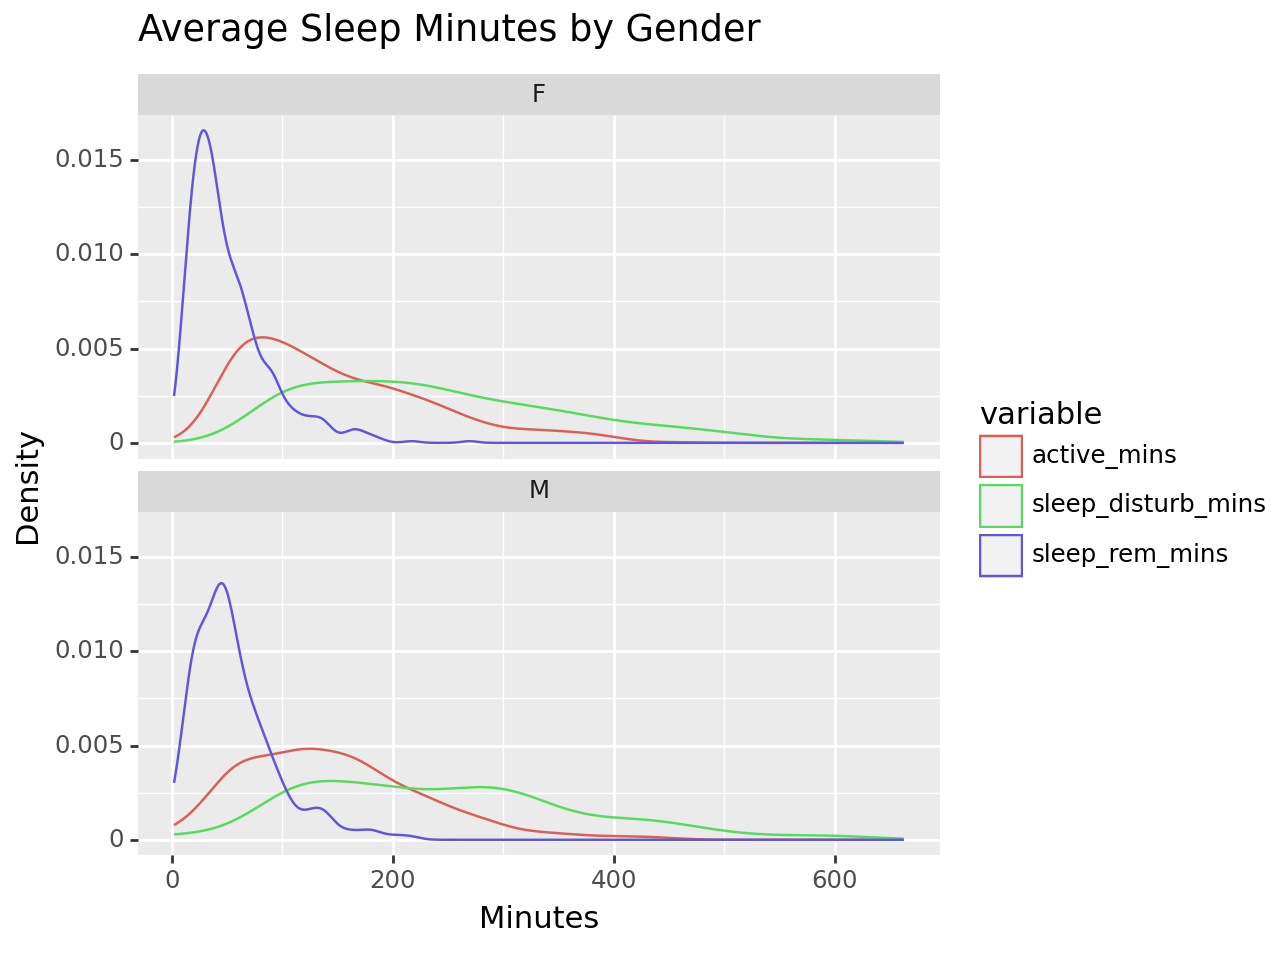

<Figure Size: (640 x 480)>

In [8]:
# Reshape the data into a stacked-long format
plt_dat = pd.melt(dat, id_vars = ['id','gender', 'age','country'])

# Filter to only the minute columns & update the value column from an object to a float
plt_dat = plt_dat[plt_dat.variable.isin(['active_mins','sleep_disturb_mins','sleep_rem_mins'])]
plt_dat['value'] = plt_dat['value'].astype('float')

# Remove the extreme age and minute outliers (we'll deal with them next)
plt_dat = plt_dat[(plt_dat.age < 100) & (plt_dat.value < 2500)]

# Plot the density distributions by Gender
(gg.ggplot(plt_dat, gg.aes(x = 'value', color = 'variable')) +
     gg.geom_density() +
     gg.xlab('Minutes') +
     gg.ylab('Density') +
     gg.ggtitle('Average Sleep Minutes by Gender') +    
     gg.facet_wrap('gender', ncol = 1))

Interesting.  There are actually some minor and subtle, but noticeable, differences between the two genders if we look at the figure above.  For starters, the men were definitely more restless as observed by their flatter "active_mins" distribution, plus a flatter and almost multimodal distribution for "disturbed sleep", compared to the women's group.  The differences in their REM sleep are minor, and would probably call for a bit more rigorous hypothesis testing.

Next, we check to see if they actual medians support our visual findings by calculating the overall medians compared to the medians for each gender.

In [9]:
#Calculate the overall median for each sleep pattern
overall = (dat.groupby(lambda x: True)[['active_mins', 'sleep_disturb_mins', 'sleep_rem_mins']]
                                           .median()
                                           .rename(index = {True: 'overall'}))

#Calculate the overall median for each sleep pattern, by gender
gender = (dat.groupby('gender')[['active_mins', 'sleep_disturb_mins', 'sleep_rem_mins']]
                                  .median()
                                  .reset_index()
                                  .set_index('gender')
                                  .rename_axis(None, axis = 'index'))

# Concatenate the overall and by-gender medians together
pd.concat([overall, gender])

,active_mins,sleep_disturb_mins,sleep_rem_mins
overall,130.50,227.05,43.8
F,128.85,223.80,40.8
M,132.75,234.45,47.3


Huh.  How about that?  There absolutely is a noticeable difference if we would have used the overall vs. the by-gender median.  Whether or not it's a statistically significant difference is another matter entirely though... more on this topic later.

For our purposes now, this is enough to conclude that a simple way to fill in the missing sleep pattern minutes would be to calculate the median values for each gender group, and then impute those values into the missing observations. I'm going to use the median instead of mean here because we know it's robust to outliers, whereas using the mean would be significantly skewed by our extreme values.

We could also have chosen to deal with our extreme values first, prior to dealing with imputations.  There's no right or wrong way, and I'll frequent flip the order of procedures depending on whatever seems to make sense for the data at hand.  My general preference is to start by removing anything I can, rows or columns, as soon as possible.  It'll only get in the way and cloud your EDA work so the faster you can get rid of useless data the better.

Let's try our median-gender group imputation method below.

In [10]:
# Impute the median value for all sleep minute NAs using the median value for each gender group
vars = ['active_mins', 'sleep_disturb_mins', 'sleep_rem_mins']
dat[vars] = dat[vars].fillna(dat.groupby('gender')[vars].transform('median'))

Nice!

And that should be it.  If we re-run our `is.na().sum()` counts we should see the fruits of our labor with all of the missing values taken care of.

In [11]:
# Count NA's by feature
dat.isna().sum()

id                    0
gender                0
age                   0
country               0
study_begin           0
study_end             0
active_mins           0
sleep_disturb_mins    0
sleep_rem_mins        0
dtype: int64

There's no end to the various methods available for imputing missing information, from very simple, to unnecessarily complex.  What we did is somewhere in the middle.  We could have also leveraged add-on Python packages that run machine learning models to predict missing values, or we could have tried some kind of unsupervised similarity methodology to see, from a mathematical point of view, which other participants look most like ours with the missing information.  No matter which you choose, they generally all do the same thing: Learning or estimating from the information available in the dataset in some way, and then generalizing and projecting those learnings onto the missing observations. 

In my experience though, most often it's not really worth the effort to go to super complicated lengths to impute values.  It ends up either going too far and introducing harmful bias to our analysis, or we could have simply removed the observation(s) without losing meaningful information, or it was complete overkill because a simple method would have worked just fine.  At the end of the day, you'll have to find what works for you in a given situation.

```{tip}
Try not to get into the habit of simply deleting data or imputing without analyzing a bit first and thinking critically about the implications.  You run the risk of losing valuable information on one hand, versus watering down your analysis on the other.
```

<h3>Anomalous Values/Outliers</h3>

Now on to the last general step of dealing with extreme values before I would start thinking about investigating variable relationships, information content, and much more robust analysis.  Extreme values are problematic for several reasons.  First, they may seriously distort the range of values for a feature, thus likely skewing any analysis we perform.  Secondly, many of the algorithms we're going to use will give undue weight to values that are more extreme.

This is a tough one because there's often very interesting information in the tails of our distributions so we'd rather not willy nilly delete everything that seems extreme; however, we need to be very careful that we don't let these outliers bias our models.

Ideally we'd love for all of our data features to be i.i.d. from a standard normal distribution, although we shouldn't hold our breath.  The best we can hope for is that we tamp down the values that will unnecessarily distort our analysis without losing too much interesting information in the process, which will ultimately give our models the best chance of finding a viable solution.

Where do we start then?  Maybe we should start with a general understanding of what are considered "outliers".

```{note}
Generally an outlier is consider to be 1.5x +/- the inner quartile range (IQR) of a feature.
```

What's an inner quartile range you're asking?  Glad you asked.  If we look at our descriptive table summary below, you'll see the min and max values, and the 25th, 50th, and 75th percentiles.  These numbers encompass the entire range of values a feature takes in your dataset.  The inner quartile range is from the 25th to 75th percentile.  Therefore, to find the "fences" for the upper and lower outlier bounds, we need to calculate 1.5x the 25th and 75th percentile numbers, and then add and subtract them to get the outlier bounds.  Anything beyond these numbers can be thought of as a bit beyond the normal central tendencies of our data.

In [12]:
dat.describe()

,age,active_mins,sleep_disturb_mins,sleep_rem_mins
count,874.000000,874.000000,874.00000,874.000000
mean,54.243707,215.030892,311.34119,121.085812
std,23.669669,818.175434,815.09168,822.545767
min,0.000000,2.000000,2.00000,2.000000
25%,35.000000,81.475000,147.70000,26.650000
50%,54.000000,130.150000,224.20000,43.400000
75%,74.000000,199.175000,321.97500,68.350000
max,146.000000,9999.000000,9999.00000,9999.000000


Like everything else, there are tons of different methods and ways we could go about addressing the extreme values in our data.  The plan is to discuss a few popular options for how it could be done, and then we'll settle on one that makes sense for this specific data.

Here's a list of what we _could_ possibly do to our outliers, and we'll discuss them in turn.

- Fix the incorrect value
- Impute/transform the value
- Delete the entire observation (row)
- Delete the entire feature (column)

Beyond our summaries, at this point we would definitely be ploting our features and distributions as well, but we'll mainly save that for the next section when we can cover them in greater detail.  For now we'll just look at what's know as a boxplot.  Boxplots are graphical representations of a feature's value range, highlighted by their percentiles (horizontal lines).  

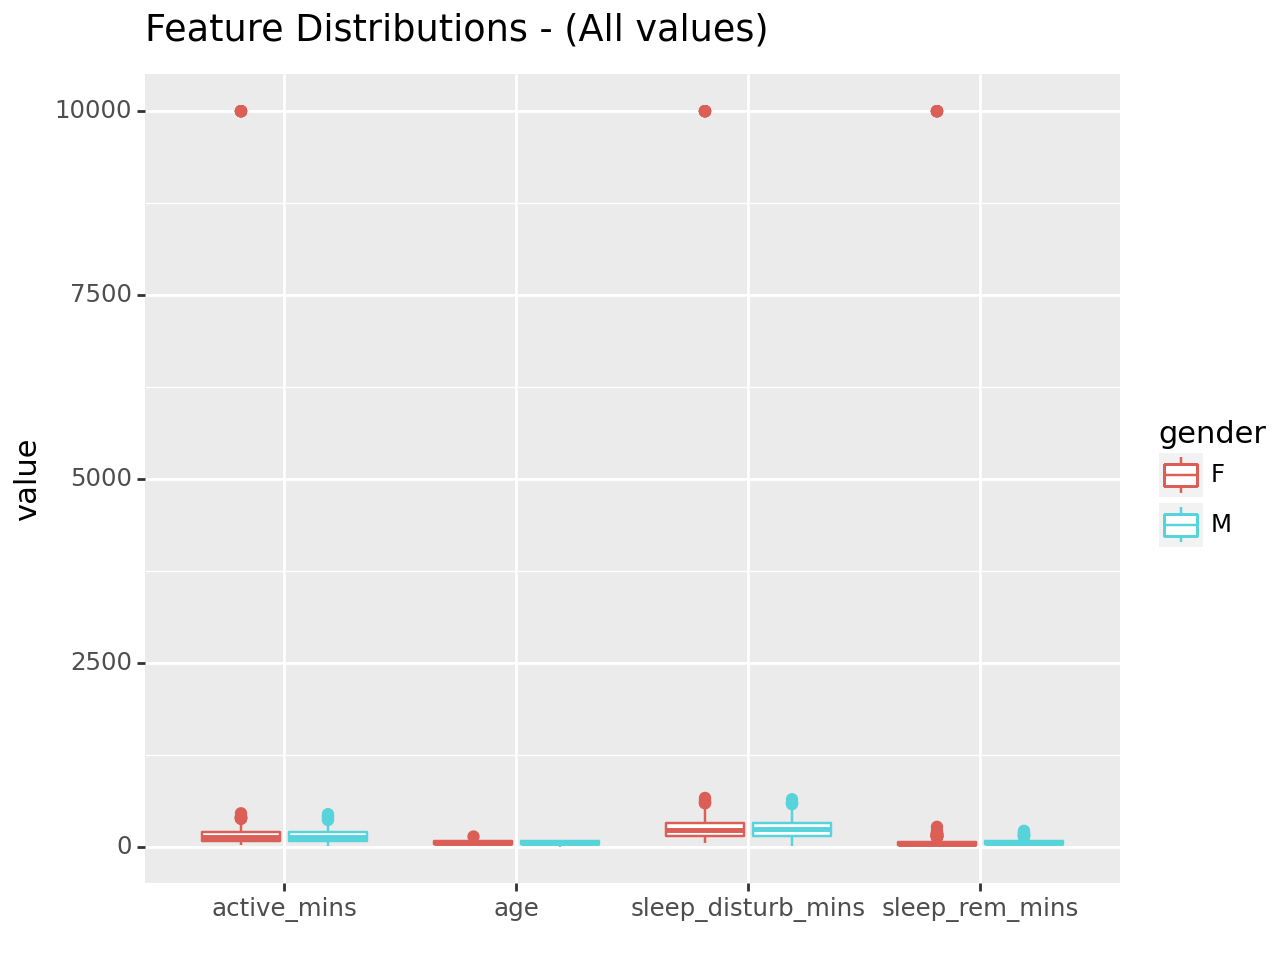

<Figure Size: (640 x 480)>

In [13]:
# Reshape the data into a stacked-long format
plt_dat = pd.melt(dat, id_vars = ['id', 'gender','country'])

# Filter to only the age and minute columns & update the value column from an object to a float
plt_dat = plt_dat[plt_dat.variable.isin(['age','active_mins','sleep_disturb_mins','sleep_rem_mins'])]
plt_dat['value'] = plt_dat['value'].astype('float')

# Plot boxplot distributions
(gg.ggplot(plt_dat, gg.aes(x = 'factor(variable)', y = 'value', color = 'gender')) +
     gg.xlab('') +
     gg.geom_boxplot() +
     gg.ggtitle('Feature Distributions - (All values)'))

As we can see above, the outliers at the top of the graph are making it nearly impossible to actually see the range of our values at the bottom of graph.  They are clearly so far out of the normal range that something is probably wrong.  Here we would start by going right back to the source with our business domain expert.  We would take our Data Quality Report and some examples and ask direct questions about how or if these values could be real.  Some of them will be obvious they're incorrect, while others may require someone with more knowledge about the topic to help.  Let's say we do so, and here's what we found out.

- __Age:__ They don't know why there are nonsense ages like 0 and 146 are showing up, but they know for sure that the minimum and maximum ages in the study were 16 and 100, respectively.
- __All Sleep Minute variables:__  The 9999 were placeholders that were never followed up on and the actual values have been lost.  We do know for a fact that no one in the study slept more than 17 hours total on average.

Given this feedback, we have a little work to do.

In [14]:
dat.describe()

,age,active_mins,sleep_disturb_mins,sleep_rem_mins
count,874.000000,874.000000,874.00000,874.000000
mean,54.243707,215.030892,311.34119,121.085812
std,23.669669,818.175434,815.09168,822.545767
min,0.000000,2.000000,2.00000,2.000000
25%,35.000000,81.475000,147.70000,26.650000
50%,54.000000,130.150000,224.20000,43.400000
75%,74.000000,199.175000,321.97500,68.350000
max,146.000000,9999.000000,9999.00000,9999.000000


We'll start with the age feature and go from there.  How many people are we talking about less than 16 and greater than 100 years of age?

In [15]:
# Filter to less than 16 or greater than 100
age_mask = (dat.age < 16) | (dat.age > 100 )
dat[age_mask]

,id,gender,age,country,study_begin,study_end,active_mins,sleep_disturb_mins,sleep_rem_mins
83,85,M,0.0,Poland,4/3/2021,4/9/2023,10.0,10.0,5.0
170,171,F,146.0,Spain,4/3/2021,4/9/2023,98.8,201.5,25.0
187,188,M,0.0,Poland,4/3/2021,4/9/2023,135.7,473.0,130.6
237,238,M,0.0,Poland,4/3/2021,4/9/2023,2.0,2.0,2.0
272,272,M,0.0,USA,4/3/2021,4/9/2023,92.2,358.4,62.3
310,310,M,0.0,Spain,4/3/2021,4/9/2023,162.7,286.7,92.0
312,312,M,0.0,Poland,4/3/2021,4/9/2023,154.3,413.4,122.0
382,382,M,0.0,Poland,4/3/2021,4/9/2023,54.9,57.2,31.0
442,442,M,0.0,Poland,4/3/2021,4/9/2023,2.0,2.0,2.0
455,455,M,0.0,Poland,4/3/2021,4/9/2023,2.0,2.0,2.0


In [16]:
# Check how many observations were in our filter mask
(age_mask == True).sum()

12

It would appear we're talking about only 12 participants with age irregularities.  We could of course remove them, but I'd rather see if we can salvage the ones that look like they have real sleep pattern minutes.  There are several with both age discrepancies _and_ clearly incorrect static values of just '2' across the board.  For these, it's just too much synthetic data if we try to impute over these values with proxies so we will remove them.

In [17]:
# Delete rows where Age = 0 & all the sleep minutes = 2 by index
dat.drop(dat[(dat.age == 0) & (dat.active_mins == 2) & (dat.sleep_disturb_mins == 2) & (dat.sleep_rem_mins == 2)].index, inplace = True)

Alright, now how many do we have left less than 16 or more than 100?

In [18]:
# Subset to see how many we have less than 16 or greater than 100
dat[(dat.age < 16) | (dat.age > 100 )]

,id,gender,age,country,study_begin,study_end,active_mins,sleep_disturb_mins,sleep_rem_mins
83,85,M,0.0,Poland,4/3/2021,4/9/2023,10.0,10.0,5.0
170,171,F,146.0,Spain,4/3/2021,4/9/2023,98.8,201.5,25.0
187,188,M,0.0,Poland,4/3/2021,4/9/2023,135.7,473.0,130.6
272,272,M,0.0,USA,4/3/2021,4/9/2023,92.2,358.4,62.3
310,310,M,0.0,Spain,4/3/2021,4/9/2023,162.7,286.7,92.0
312,312,M,0.0,Poland,4/3/2021,4/9/2023,154.3,413.4,122.0
382,382,M,0.0,Poland,4/3/2021,4/9/2023,54.9,57.2,31.0
786,786,M,0.0,Poland,4/3/2021,4/9/2023,139.3,198.2,123.6


We'll take a simple gamble on the remaining age issues to keep from having to remove another 8 observations.  We'll assume that anything less than 16 should be the minimum, and anything over 100 should be the maximum.  

In [19]:
# Impute for less than 16 and greater than 100
dat.loc[dat.age < 16, 'age'] = 16
dat.loc[dat.age > 100, 'age'] = 100
dat[['age']].describe().T

,count,mean,std,min,25%,50%,75%,max
age,870.0,54.568966,23.021363,16.0,35.0,54.0,74.0,100.0


Awesome!  Age looks to be all taken care of now.  Let's turn our attention to the sleep minutes.  We know that all of the 9999 placeholders are bogus and we have no expectation of collecting the real data.  So what can we do?  We can either impute or transform them in some way, or delete the observations.  Let's see how many are involved before we decide.

In [20]:
# Filter to all of the 9999 values
dat[(dat.active_mins == 9999) | (dat.sleep_disturb_mins == 9999) | (dat.sleep_rem_mins == 9999)]

,id,gender,age,country,study_begin,study_end,active_mins,sleep_disturb_mins,sleep_rem_mins
115,116,F,94.0,Italy,4/3/2021,4/9/2023,9999.0,9999.0,9999.0
179,180,F,24.0,Italy,4/3/2021,4/9/2023,9999.0,9999.0,9999.0
196,197,F,78.0,Italy,4/3/2021,4/9/2023,9999.0,9999.0,9999.0
630,630,F,38.0,Italy,4/3/2021,4/9/2023,9999.0,9999.0,9999.0
661,661,F,33.0,Italy,4/3/2021,4/9/2023,9999.0,9999.0,9999.0
751,751,F,95.0,Italy,4/3/2021,4/9/2023,9999.0,9999.0,9999.0


These values highlight an important distinction between outliers and _extreme_ values.  Outliers are typically regarded as real data and could actually be the values you want to study.  Extreme values could possibly be real, however they are so far outside of what's considered normal for a model that's trying to learn what "typical" looks like.  You may want to see them, but most often we're working with models that learn "on the averages" what "normal" conditions and behaviors are.  These extreme values typically hamper that effort.  

In our case, they're not even really extreme values, so much as they're completely fake data used as placeholders to indicate the researcher did not have the results when it was time to record their observations.  Because of that, there's really nothing I'd recommend we try to do to guess what they might have been.  Unfortunatley it's another case of dropping these participant observations from our set.

In [21]:
# Delete 9999 placeholder observations
dat.drop(dat[(dat.active_mins == 9999) | (dat.sleep_disturb_mins == 9999) | (dat.sleep_rem_mins == 9999)].index, inplace = True)

Looking good!  One more thing we need to check now.  Remember our business sponsor told us no one slept more than 17 hours total on average?  Let's make sure that's what we see in the data by creating a "sleep_total_mins" variable.

In [22]:
# Create a "total" sleep minutes variable
dat['sleep_total_mins'] = dat[['active_mins','sleep_disturb_mins','sleep_rem_mins']].sum(axis = 'columns')

# Check if any of the toal sleep minutes add up to more than 17 hours
(dat.sleep_total_mins > 17 * 60).any()

False

Whew... all good there.

Now let's take a look at our boxplot and see if our distributions make a little more sense.

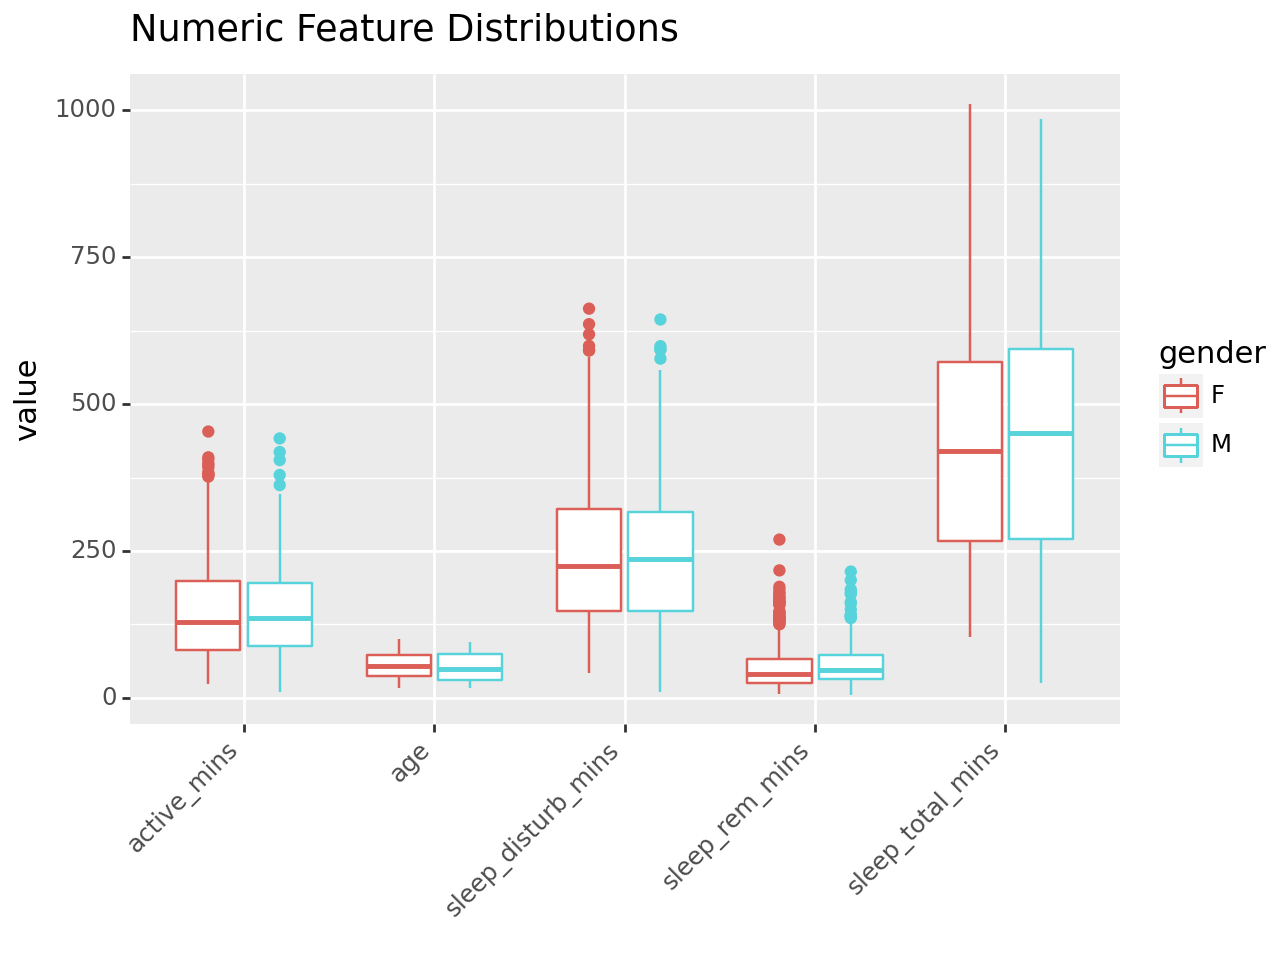

<Figure Size: (640 x 480)>

In [23]:
# Reshape the data into a stacked-long format
plt_dat = pd.melt(dat, id_vars = ['id', 'gender','country'])

# Filter to only the age and minute columns & update the value column from an object to a float
plt_dat = plt_dat[plt_dat.variable.isin(['age','active_mins','sleep_disturb_mins','sleep_rem_mins','sleep_total_mins'])]
plt_dat['value'] = plt_dat['value'].astype('float')

# Plot boxplot distributions
(gg.ggplot(plt_dat, gg.aes(x = 'factor(variable)', y = 'value', color = 'gender')) +
     gg.xlab('') +
     gg.geom_boxplot() + 
     gg.theme(axis_text_x = gg.element_text(rotation = 45, hjust = 1)) +
     gg.ggtitle('Numeric Feature Distributions'))

Great!  Removing the extreme values shortened up our ranges so now we can actually see what's going on.  They way these box plots work is the dots you see are actually what we've labeled as outliers.  Those are the values past the 1.5x IQR +/- fences.  We definitely have a few remaining variables beyond those thresholds, but for now I think we'll leave them alone and deal with them when we get to the {doc}`../Chapter5/feat_engineering` and transformations section.  Hopefully they'll get smoothed out then, or we may apply what's known as a "clamp transformation" by imputing to the 1.5x IQR values.  Stay tuned.

Lastly, don't forget that we need to handle the categorical variables which shouldn't take too long.  Let's print them below.

In [24]:
# Print categorical summary stats
dat[['id','gender','country','study_begin','study_end']].describe()

,id,gender,country,study_begin,study_end
count,864,864,864,864,864
unique,864,2,4,1,1
top,1,F,Italy,4/3/2021,4/9/2023
freq,1,606,338,864,864


Ok, looks like all we need to deal with are the dates.  We've already discussed that removing any feature which is completely static, or exactly the same for every observation, should be removed because it holds no information.  You may want to peel these off and hold them as meta data of some sort so you don't lose the information entirely, but for our analysis and modeling purposes, get them out of the way by dropping them.

From the table above, we can see that only the dates are completely static because they only have one unqiue value count.  Get rid of them!

In [25]:
dat.drop(['study_begin', 'study_end'], axis = 1, inplace = True)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 864 entries, 0 to 876
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  864 non-null    object 
 1   gender              864 non-null    object 
 2   age                 864 non-null    float64
 3   country             864 non-null    object 
 4   active_mins         864 non-null    float64
 5   sleep_disturb_mins  864 non-null    float64
 6   sleep_rem_mins      864 non-null    float64
 7   sleep_total_mins    864 non-null    float64
dtypes: float64(5), object(3)
memory usage: 60.8+ KB


And that's finally it for now!  Nicely done.  I'm sure this seemed like a ton of stuff all over the place thrown at you, but it does become more habitual the more you practice.  And usually you'll jump in and just start noticing things that look odd, start investigating, and it'll lead you right to where you need to go.  We also did most of this without the aid of plots and graphs, which are a _huge_ benefit to our EDA work.  It would have simply been too much to try and teach EDA plus plots at the same time.  This is where we head next!